# WEST IC C4 Conditioning Campaign 

In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import matplotlib.dates as mdates
import datetime

# Creating the database

In [3]:
def read_conditoning_data(filename):
    """
    Import and return the ICRH Conditioning data into a pandas DataFrame
    """

    data = pd.read_csv(filename, delimiter='\t', skiprows=18, 
                names=('Temps',
                       'PiG','PrG','PiD','PrD',
                       'V1','V2','V3','V4', 
                       'Ph(V1-V3)','Ph(V2-V4)',
                       'Consigne_mes', 'Vide_gauche', 'Vide_droit',
                       'reserve1', 'reserve2', '_'),
                index_col='Temps') # last element '_' to avoid pandas crashing
    # convert phase in degree and wrap it between 0° and 359°
    data['Ph(V1-V3)'] /= 100
    data['Ph(V2-V4)'] /= 100
    #data['Ph(V1-V3)'] %= 360
    #data['Ph(V2-V4)'] %= 360
    return data 

def read_conditioning_metadata(filename):
    """
    Import and return the ICRH Conditioning metadata into a dictionary
    """
    para_dic = {}
    with  open(filename,'r') as cmt_file:    # open file
        for line in cmt_file:    # read each line
            if line[0] == '#':    # check the first character
                line = line[1:]    # remove first '#'
                para = line.split('=')     # seperate string by '='
                if len(para) == 2:
                    para_dic[ para[0].strip()] = para[1].strip()
    return para_dic 

In [17]:
file = 'Conditionning/2019-07-05_10-14-12.csv'
'''
Get the metadata of a file and generate a pandas DataFrame of them
'''
def forge_df(file):
    metadata = read_conditioning_metadata(file)
    _datetime = pd.datetime.strptime(metadata['Date']+' '+metadata['Heure'], '%Y-%m-%d %H-%M-%S')
    _row = pd.DataFrame(data={'Date':_datetime, 
                       'Antenna':int(metadata['Antenne'][1]), 
                       'Duration':float(metadata['Duree du tir'].split()[0]),
                       'Frequency':float(metadata['Frequence'].split()[0]),
                       'Nb of Vr/Vi':int(metadata['Nb interruptions TOS']),
                       'Nb of SHAD': int(metadata['Nb interruptions SHAD']),
                       'Nb of Optical':int(metadata['Nb interruptions OPT']),
                       'Nb total': int(metadata['Nb interruptions TOTAL']),
                       'Vacuum stop': int(metadata['Arret sur defaut vide'])
                      }, index=[0])#.set_index('Date')

    _all_data = read_conditoning_data(file)
    _data = pd.DataFrame(_all_data.max()).T
    #_data['Date'] = _row.index
    #_data = _data.set_index(_data['Date'])
    _row_final = pd.concat([_data, _row], axis=1)
    _row_final.set_index('Date')
    # power must be divided by 10 to get kW
    _row_final['PiG'] = _row_final['PiG']/10
    _row_final['PiD'] = _row_final['PiD']/10
    # Energy
    _row_final['Energie_Left'] = np.trapz(_all_data.PiG/10*1e3, _all_data.index/1e6)
    _row_final['Energie_Right'] = np.trapz(_all_data.PiD/10*1e3, _all_data.index/1e6)
   
    return _row_final

In [18]:
files = glob('Conditionning/*.csv')

In [19]:
df = pd.DataFrame()
for file in tqdm(files):
    df=df.append(forge_df(file))
df=df.set_index('Date')

  0%|                                                                                         | 0/1148 [00:00<?, ?it/s]C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
100%|██████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:17<00:00, 67.28it/s]


# Ploting the results

## Power vs Date

<IPython.core.display.Javascript object>


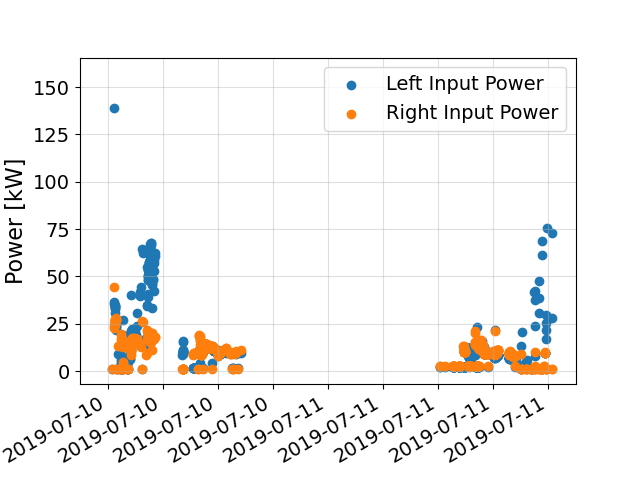

(18087.25, 18088.75)

In [21]:
fig, ax = plt.subplots()
ax.scatter(df.index, df['PiG'], label='Left Input Power')
ax.scatter(df.index, df['PiD'], label='Right Input Power')

ax.grid(True, alpha=0.4)
ax.tick_params(labelsize=14)
ax.set_ylabel('Power [kW]', fontsize=16)
format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(format_xdata)
fig.autofmt_xdate()
ax.legend( fontsize=14)
ax.set_xlabel('', fontsize=16)
ax.set_xlim(left=datetime.datetime(2019, 7, 10, 6, 0), right=datetime.datetime(2019, 7, 11, 18,0))


## Voltage vs Date

<IPython.core.display.Javascript object>


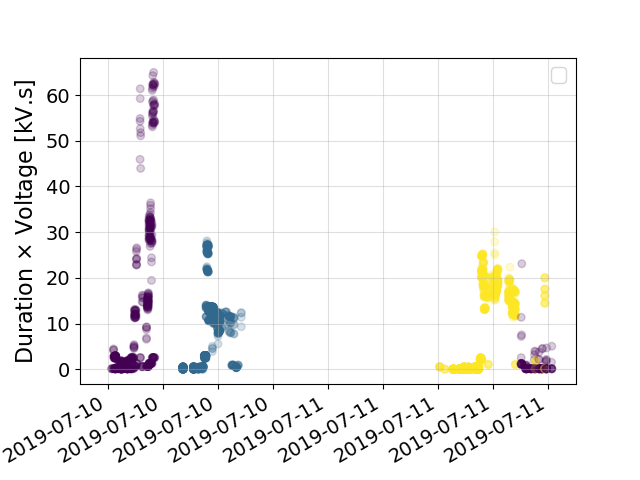

No handles with labels found to put in legend.


(18087.25, 18088.75)

In [7]:
fig, ax = plt.subplots()
ax.scatter(df.index, df['Duration'] * df['V1']/1e3, c=df['Antenna'], label='', s=30, alpha=0.2)
ax.scatter(df.index, df['Duration'] * df['V2']/1e3, c=df['Antenna'], label='', s=30, alpha=0.2)
ax.scatter(df.index, df['Duration'] * df['V3']/1e3, c=df['Antenna'], label='', s=30, alpha=0.2)
ax.scatter(df.index, df['Duration'] * df['V4']/1e3, c=df['Antenna'], label='', s=30, alpha=0.2)

ax.grid(True, alpha=0.4)
ax.tick_params(labelsize=14)
ax.set_ylabel(r'Duration $\times$ Voltage [kV.s]', fontsize=16)
format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(format_xdata)
fig.autofmt_xdate()
ax.legend( fontsize=14)
ax.set_xlabel('', fontsize=16)
ax.set_xlim(left=datetime.datetime(2019, 7, 10, 6, 0), right=datetime.datetime(2019, 7, 11, 18,0))

## Energy vs Date

<IPython.core.display.Javascript object>


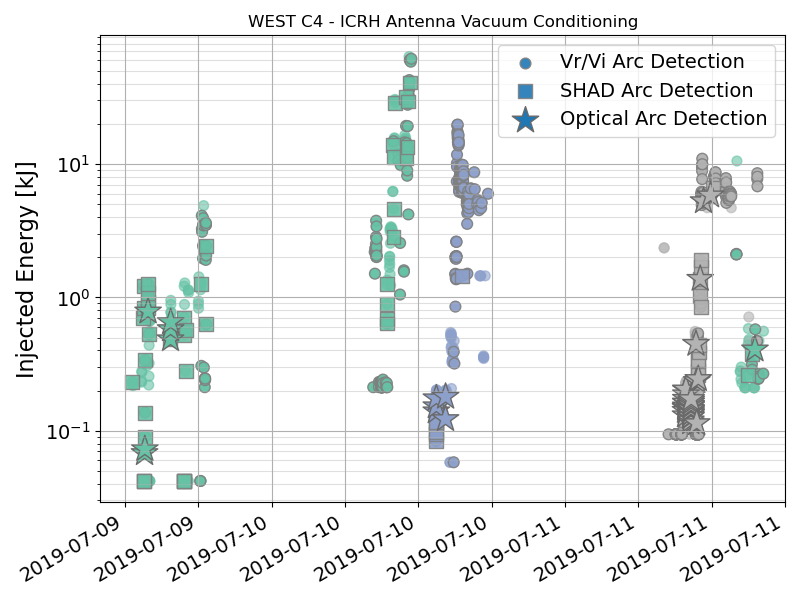

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
Etot = df.Energie_Left/1e3 + df.Energie_Right/1e3
ax.scatter(df.index, Etot, c=df.Antenna, label='', s=50, cmap='Set2', alpha=0.6)
#ax.scatter(df.index, , c=df.Antenna, label='', s=50)
ax.scatter(df.index[df['Nb of Vr/Vi'] > 0], Etot[df['Nb of Vr/Vi'] > 0], marker='o', 
           c=df.Antenna[df['Nb of Vr/Vi'] > 0], alpha=.9, s=60, label='Vr/Vi Arc Detection', cmap='Set2', edgecolor='gray')
ax.scatter(df.index[df['Nb of SHAD'] > 0], Etot[df['Nb of SHAD'] > 0], alpha=.9, marker='s',  
           c=df.Antenna[df['Nb of SHAD'] > 0], s=100, label='SHAD Arc Detection', cmap='Set2', edgecolor='gray')
ax.scatter(df.index[df['Nb of Optical'] > 0], Etot[df['Nb of Optical'] > 0], marker='*', 
           c=df.Antenna[df['Nb of Optical'] > 0], s=400, label='Optical Arc Detection', cmap='Set2', edgecolor='dimgray')


ax.set_yscale('log')
ax.grid(True)
ax.grid(True, which='minor', alpha=.4)
ax.tick_params(labelsize=14)
ax.set_ylabel('Injected Energy [kJ]', fontsize=16)
format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(format_xdata)
fig.autofmt_xdate()
ax.legend( fontsize=14)
ax.set_xlabel('', fontsize=16)

ax.set_xlim(left=datetime.datetime(2019, 7, 9, 10, 0), right=datetime.datetime(2019, 7, 11, 18,0))
ax.set_title('WEST C4 - ICRH Antenna Vacuum Conditioning')
fig.tight_layout()
#fig.savefig('WEST_C4_energy_vs_date.png', dpi=150)

## Pressure vs Date 

<IPython.core.display.Javascript object>


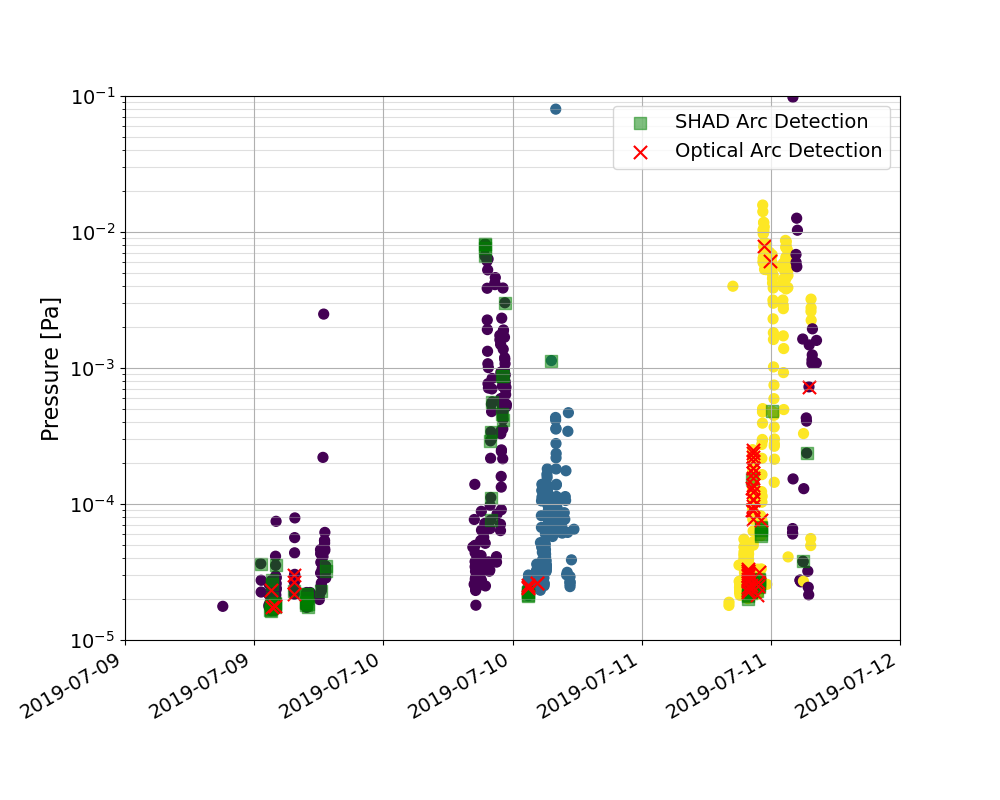

Text(0.5, 0, '')

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(df.index, np.power(10, 1.667*df.Vide_gauche*1e-3 - 9.33), c=df.Antenna, label='', s=50)
ax.scatter(df.index[df['Nb of SHAD'] > 0], np.power(10, 1.667*df.Vide_gauche*1e-3 - 9.33)[df['Nb of SHAD'] > 0], alpha=.5, marker='s', color='g', s=70, label='SHAD Arc Detection')
ax.scatter(df.index[df['Nb of Optical'] > 0], np.power(10, 1.667*df.Vide_gauche*1e-3 - 9.33)[df['Nb of Optical'] > 0], marker='x', color='r', s=90, label='Optical Arc Detection')
#ax.scatter(df.index[df['Nb of Vr/Vi'] > 0], np.power(10, 1.667*df.Vide_gauche*1e-3 - 9.33)[df['Nb of Vr/Vi'] > 0], marker='.', color='gray', alpha=.8, s=70, label='Vr/Vi Arc Detection')


ax.set_xlim(left=datetime.date(2019, 7, 9), right=datetime.date(2019, 7, 12))
ax.set_ylim(1e-5, 1e-1)
ax.set_yscale('log')
ax.grid(True)
ax.grid(True, which='minor', alpha=.4)
ax.tick_params(labelsize=14)
ax.set_ylabel('Pressure [Pa]', fontsize=16)
format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(format_xdata)
fig.autofmt_xdate()
ax.legend(fontsize=14)
ax.set_xlabel('', fontsize=16)

#ig.savefig('WEST_C4_pressure_vs_date.png', dpi=150)